In [17]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import time

# 1 Data Preprocessing

Dataset: [Cifar10](https://www.cs.toronto.edu/~kriz/cifar.html), contains 60000 32x32x3 images from 10 different classes, 50000 training and 10000 test images

Task: Image classification task 

In [18]:
#Load the training and test datasets
training_ds, test_ds = tfds.load(
    name = "cifar10",
    split = ['train', 'test'],
    as_supervised = True
)

In [19]:
#Mapping the label number to actual textual labels
numbertolabel={0:"airplane", 1:"automobile", 2:"bird", 3:"cat",4: "deer", 5:"dog", 6:"frog", 7:"horse",8:"ship", 9:"truck"}
def itswhatagain(n):
  return numbertolabel[n]

itswhatagain(1)

'automobile'

In [20]:
def show5(data, type=tf.int64):
  #shows the first five images of the dataset
  fig, ax = plt.subplots(1,5)
  c=0
  for i in data.take(5):
      img = i[0]
      lbl = itswhatagain(int(i[1]))
      
      ax[c].imshow((tf.cast(img,dtype=type)), cmap='gray')
      ax[c].set_title(img.shape)
      ax[c].set_title(lbl)
      ax[c].axis("off")
      c = c+1


(32, 32, 3)
()
tf.Tensor(7, shape=(), dtype=int64)
(32, 32, 3)
()
tf.Tensor(8, shape=(), dtype=int64)
(32, 32, 3)
()
tf.Tensor(4, shape=(), dtype=int64)
(32, 32, 3)
()
tf.Tensor(4, shape=(), dtype=int64)
(32, 32, 3)
()
tf.Tensor(6, shape=(), dtype=int64)


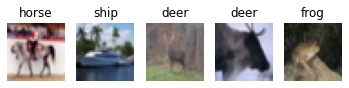

In [21]:
#Inspect the images and the labels
for sample in training_ds.take(5):
  print(sample[0].shape)
  print(sample[1].shape)
  print(sample[1])

show5(training_ds)

In [22]:
#Defining some normalizing functions
def normalize_0_1(x):
  #range 0 to 1
  max = tf.math.reduce_max(x)
  min = tf.math.reduce_min(x)
  result = tf.math.subtract(x, min)
  result = tf.math.divide(result,(max-min))
  return(result)

def normalize_neg_1(x):
  #range -1 to 1
  result = normalize_0_1(x)
  result = tf.math.multiply(result,2)
  result = tf.math.subtract(result,1)
  return(result)

def normalize_std(x): #This one delivered better accuracy, which is why we are using it
  #range according gaussian standard distribution
  return tf.image.per_image_standardization(x)

# Data input pipeline

In [23]:
def prepare(ds, shuffle=False, augment=False): #generates a resized, normalized, shuffled,, batched and prefetched ds
  # Resize and rescale all datasets
  ds = ds.map(lambda img, label:(tf.image.resize(img, [32,32]), tf.one_hot(label, 10)))
  ds = ds.map(lambda img, label:(normalize_std(img), label))
  if shuffle:
    ds = ds.shuffle(buffer_size = 128)
  ds = ds.batch(64)

  # Use prefetching on all datasets, Prefetch Size is determined during runtime
  ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
  
  return ds

In [24]:
#Now we prepare all our datasets 
train_data = prepare(training_ds, shuffle=True, augment=False)
test_data = prepare(test_ds, shuffle=True)

#2.) Model

2.1)**ResNet**

2.1.1) Define Residual Block

We implement a residual Block with the following Architecture with BatchNorm added inbetween the CovLayers: 


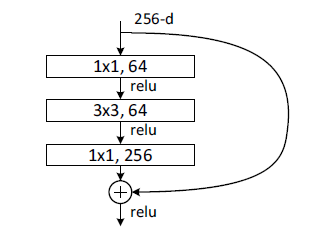

In [46]:
class ResidualBlock(tf.keras.layers.Layer):

  def __init__(self, channels = 256, num_filter = 64):
    """
    channels: dimension of input channels 
    """
    super(ResidualBlock, self).__init__()

    #Define Layers for the block (dimension does not change input_dim = output_dim)
    
    #use the same activation, initializer and regularizer for all covs
    activation = tf.keras.activations.relu
    regularizer = tf.keras.regularizers.l2(0.01)
    initializer = tf.keras.initializers.GlorotUniform

    self.conv1 = tf.keras.layers.Conv2D(filters = num_filter,
                                        kernel_size = (1,1),
                                        strides = (1,1),
                                        padding = "same",
                                        activation = None,
                                        kernel_initializer = initializer,
                                        kernel_regularizer = regularizer
                                        )
    self.batch_norm1 = tf.keras.layers.BatchNormalization()
    self.conv1_activation = activation
    self.conv2 = tf.keras.layers.Conv2D(filters = num_filter,
                                        kernel_size = (3,3),
                                        strides = (1,1),
                                        padding = "same",
                                        activation = None,
                                        kernel_initializer = initializer,
                                        kernel_regularizer = regularizer
                                        )
    self.batch_norm2 = tf.keras.layers.BatchNormalization()
    self.conv2_activation = activation
    self.conv3 = tf.keras.layers.Conv2D(filters = channels,
                                        kernel_size = (1,1),
                                        strides = (1,1),
                                        padding = "same",
                                        activation = None,
                                        kernel_initializer = initializer,
                                        kernel_regularizer = regularizer
                                        )
    self.batch_norm3 = tf.keras.layers.BatchNormalization()
    self.conv3_activation = activation

  @tf.function
  def call(self, x, training = True):
    #save identity (input) for adding later
    #tf.identity
    identity = tf.identity(x)

    x = self.conv1(x)
    x = self.batch_norm1(x, training)
    x = self.conv1_activation(x)
    x = self.conv2(x)
    x = self.batch_norm2(x, training)
    x = self.conv2_activation(x)
    x = self.conv3(x)
    x = self.batch_norm3(x, training)
    #Adding Identity
    x = x + identity
    #last activation is applied after adding the identity
    x = self.conv3_activation(x)
    
    return x

In [47]:
#Check whether the ResBlock works (input_dim = output_dim)
for i in train_data.take(1):
  print(i[0].shape)
  block = ResidualBlock(channels = 3)
  y = block(i[0])
  print(y.shape)

(64, 32, 32, 3)
(64, 32, 32, 3)


2.1.2) Defining the ResNet

Our ResNet consists of a convolutional Layers followed by several ResBlocks and an linear output layer

In [27]:
class ResNet(tf.keras.Model):

  def __init__(self, num_block = 4, channels_in_block = 256):
    super(ResNet, self).__init__()

    #starting with a ConvLayer witch BatchNorm
    self.conv1 = tf.keras.layers.Conv2D(filters = channels_in_block,
                                        kernel_size = (3,3),
                                        strides = (1,1),
                                        padding = "same",
                                        activation = None,
                                        input_shape = (32,32,3)                                        
                                        )
    self.batch_norm1 = tf.keras.layers.BatchNormalization()
    self.conv1_activation = tf.keras.activations.relu
    
    #Dynamically generate ResBlocks
    self.ResBlocks = []
    for i in range(num_block):
      n_channels = channels_in_block 
      n_filters = 64 * np.power(2,i)
      print("Block " + str(i+1))
      print("n_channel: " + str(n_channels))
      print("n_filters: " + str(n_filters))
      self.ResBlocks.append(ResidualBlock(channels = n_channels, num_filter = n_filters))
      if (i+1)%2 == 0:
        #MaxPooling after every 2 ResBlocks
        self.ResBlocks.append(tf.keras.layers.MaxPool2D())

    self.GlobalAvgPool = tf.keras.layers.GlobalAveragePooling2D()
    self.output_layer = tf.keras.layers.Dense(units = 10,
                                        activation = tf.keras.activations.softmax)
  @tf.function
  def call(self, x, training = True):
    x = self.conv1(x)
    x = self.batch_norm1(x, training)
    x = self.conv1_activation(x)

    #pass input through all ResBlocks
    for block in self.ResBlocks:
      if(isinstance(block, ResidualBlock)):
        x = block(x, training)
      else:
        x = block(x)
      
    
    x = self.GlobalAvgPool(x)
    x = self.output_layer(x)

    return x

2.2) **DenseNet**

2.2.1) DenseNet Block

A really good explanation can be found here:
https://towardsdatascience.com/review-densenet-image-classification-b6631a8ef803


In [59]:
class DenseNetBlock(tf.keras.layers.Layer):

  def __init__(self, k=32):

    super(DenseNetBlock, self).__init__()

    #Define Layers for the block (dimension does not change input_dim = output_dim)
    
    #use the same activation for all covs
    activation = tf.keras.activations.relu

    #Batching --> Relu --> Bottleneck
    self.batch_norm1 = tf.keras.layers.BatchNormalization()
    self.conv1_activation = activation
    self.conv2 = tf.keras.layers.Conv2D(filters = k*4,
                                        kernel_size = (1,1),
                                        strides = (1,1),
                                        padding = "same",
                                        activation = None)
    
    #Batching --> Relu --> Convolution
    self.batch_norm2 = tf.keras.layers.BatchNormalization()
    self.conv2_activation = activation
    self.conv3 = tf.keras.layers.Conv2D(filters = k, 
                                        kernel_size = (3,3),
                                        strides = (1,1),
                                        padding = "same",
                                        activation = None
                                        )


  @tf.function
  def call(self, x, training = True):
    
    #save identity (input) for adding later
    identity = tf.identity(x)

    x = self.batch_norm1(x, training)
    x = self.conv1_activation(x)
    x = self.conv2(x)
    x = self.batch_norm2(x, training)
    x = self.conv2_activation(x)
    x = self.conv3(x)
    
    
    #Concatenating Identity
    #print(x.shape)
    #print(identity.shape)
    x = tf.concat([x,identity],-1)
    #print(x.shape)
    
    return x




#A class for the intermediate-Layers
class IntermediateBlock(tf.keras.layers.Layer):

  def __init__(self):

    super(IntermediateBlock, self).__init__()

    #Define Layers for the block (dimension does not change input_dim = output_dim)
    
    #use the same activation for all covs
    activation = tf.keras.activations.relu


    self.conv = tf.keras.layers.Conv2D(filters = 128,
                                        kernel_size = (1,1),
                                        strides = (1,1),
                                        padding = "same",
                                        activation = None)
    self.batch_norm = tf.keras.layers.BatchNormalization()
    self.conv_activation = activation
    self.pooling = tf.keras.layers.AveragePooling2D(
                      pool_size=(2, 2), strides=None)

  @tf.function
  def call(self, x, training = True):
    #save identity (input) for adding later

    x = self.conv(x)
    x = self.batch_norm(x, training)
    x = self.conv_activation(x)
    x = self.pooling(x)
    
    return x

2.2.2) DenseNet

In [60]:
class DenseNet(tf.keras.Model):

  def __init__(self, num_block = 4):
    super(DenseNet, self).__init__()

    self.conv1 = tf.keras.layers.Conv2D(filters = 128,
                                        kernel_size = (3,3),
                                        strides = (1,1),
                                        padding = "same",
                                        activation = None,
                                        input_shape = (32,32,3)                                        
                                        )




    
    
    #Dynamically generate DenseBlocks
    self.Blocks = []
    for i in range(num_block):
      self.Blocks.append(DenseNetBlock(k=32))
      if i != num_block-1: #between each of the layers, we also need an Intermediate Block, except for the last layer
        self.Blocks.append(IntermediateBlock())
      
  

    self.GlobalAvgPool = tf.keras.layers.GlobalAveragePooling2D()
    self.output_layer = tf.keras.layers.Dense(units = 10,
                                        activation = tf.keras.activations.softmax)
  @tf.function
  def call(self, x, training = True):
    x = self.conv1(x)

    #pass input through all DenseBlocks
    for block in self.Blocks:
      x = block(x,training)
    

    x = self.GlobalAvgPool(x)
    x = self.output_layer(x)

    return x

# 3. Training

**3.1) DenseNet**

In [61]:
#General Hyperparameters
trainforNepochs=30                                    
learning_rate=0.0002                                       
running_average_factor = 0.95                           
lossfunction= tf.keras.losses.CategoricalCrossentropy()       #we use categorical cross entropy as lossfunction
optimizer = tf.keras.optimizers.Adam(learning_rate)           #we use ADAM as optimizer

tf.keras.backend.clear_session()
model=DenseNet(num_block = 4)

In [62]:
@tf.function
def train_step(model, input, target, loss_function, optimizer, training=True):
  # loss_object and optimizer_object are instances of respective tensorflow classes
  with tf.GradientTape() as tape: #we safe the loss in the gradient tape 
    prediction = model(input, training)
    loss = loss_function(target, prediction)
    gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss 

def test(model, test_data, loss_function, training=False):
  # test over complete test data
  test_accuracy_aggregator = []
  test_loss_aggregator = []

  for (input, target) in test_data:
    prediction = model(input, training)
    sample_test_loss = loss_function(target, prediction)
    #Comparing the ratio of rightly classified images by looking at the index with max. probability 
    sample_test_accuracy = np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
    sample_test_accuracy = np.mean(sample_test_accuracy)
    test_loss_aggregator.append(sample_test_loss)
    test_accuracy_aggregator.append(np.mean(sample_test_accuracy))

  test_loss = np.mean(test_loss_aggregator)
  test_accuracy = np.mean(test_accuracy_aggregator)

  return test_loss, test_accuracy

In [64]:
# Initialize lists for later visualization.
train_losses = []
test_losses = []
test_accuracies = []

#testing once before we begin, so that be have the first datapoints
test_loss, test_accuracy = test(model, test_data, lossfunction)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

#check how model performs on train data once before we begin, so that we have a baseline
train_loss, _ = test(model, train_data, lossfunction)
train_losses.append(train_loss)

In [65]:
#After training once the model is built and we can look at its architecture and its parameters
print(model.summary())

Model: "dense_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  3584      
_________________________________________________________________
dense_net_block (DenseNetBlo multiple                  54432     
_________________________________________________________________
intermediate_block (Intermed multiple                  21120     
_________________________________________________________________
dense_net_block_1 (DenseNetB multiple                  54432     
_________________________________________________________________
intermediate_block_1 (Interm multiple                  21120     
_________________________________________________________________
dense_net_block_2 (DenseNetB multiple                  54432     
_________________________________________________________________
intermediate_block_2 (Interm multiple                  21

In [34]:
def viz(train_losses,test_losses,test_accuracies):
  plt.figure()
  line1, = plt.plot(train_losses,'r--')
  line2, = plt.plot(test_losses, 'b-')
  plt.xlabel("Training steps")
  plt.ylabel("Loss")
  plt.legend((line1,line2),("training","test"))
  plt.show()

  # One plot training and test accuracy.
  plt.figure()
  line1, = plt.plot(test_accuracies)
  plt.xlabel("Training steps")
  plt.ylabel("Accuracy")
  plt.show()

Training Loop

In [35]:
def highest_index(Array):
  x=max(Array)
  return x, Array.index(x)

This Plot was generated after 2 Epochs of training.
The test accuracy was: 0.5944466560509554 .
The highest accuracy so far was 0.5944466560509554 in epoch 2


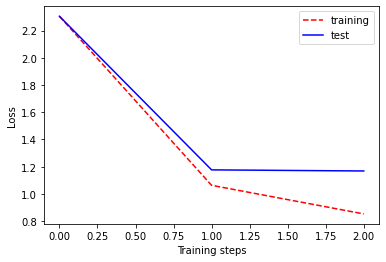

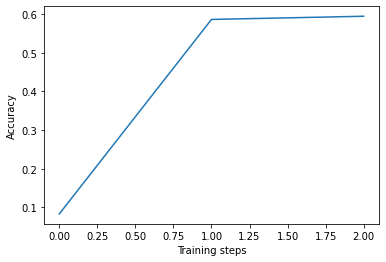

This Plot was generated after 10 Epochs of training.
The test accuracy was: 0.6944665605095541 .
The highest accuracy so far was 0.703125 in epoch 9


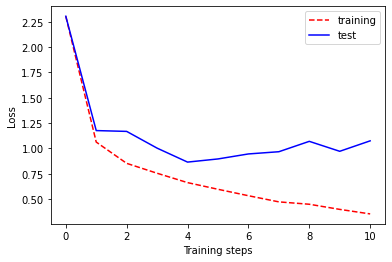

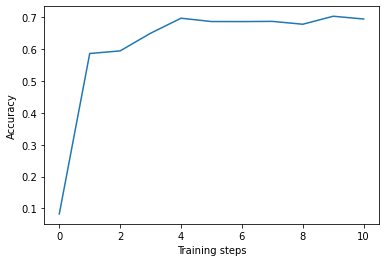

This Plot was generated after 20 Epochs of training.
The test accuracy was: 0.7447253184713376 .
The highest accuracy so far was 0.7619426751592356 in epoch 17


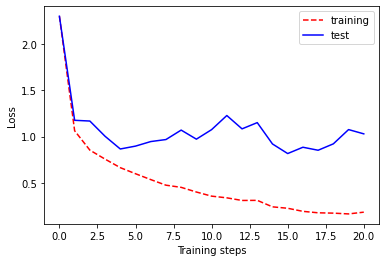

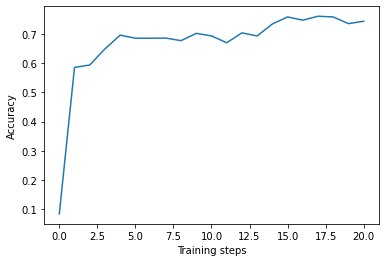

This Plot was generated after 30 Epochs of training.
The test accuracy was: 0.7549761146496815 .
The highest accuracy so far was 0.7619426751592356 in epoch 17


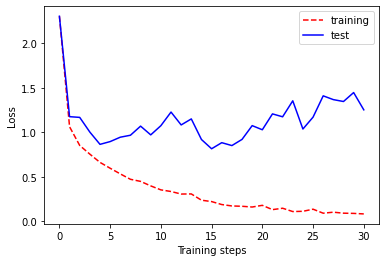

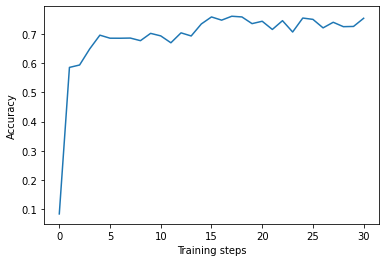

Finished after 643.0 seconds.


In [36]:
# We train for trainforNepochs epochs.
for epoch in range(trainforNepochs):

    #!!!!!!!!!!!!just some fun runtime approximation that you can ignore :D
    if epoch == 0:              #before the first epoch we dont know how much time is going to pass.
      start = time.time()       #what we know is, when we started!
      time_remaining="Unknown"
    else:
      now = time.time()                                         
      time_per_epoch = ((now-start)/epoch)                      #average of the time per epoch
      remaining_epochs = trainforNepochs-epoch                  #numbers of remaining epochs
      time_remaining = round(time_per_epoch*remaining_epochs,0)
    print("",end="\r")
    print('Epoch:',str(epoch + 1 ),"of",str(trainforNepochs)+" Time remaining:", time_remaining, "seconds.       "+"["+"="*int((epoch/trainforNepochs)*100)+"-"*int(((trainforNepochs-epoch)/trainforNepochs)*100)+"]", end="")
    #!!!!!!!!!!!end of the runtime approximation
    


    #training (and checking in with training)
    running_average = 0
    for (input,target) in train_data:                           #Training the model as long as we have training data
        train_loss = train_step(model, input, target, lossfunction, optimizer)
        running_average = running_average_factor * running_average  + (1 - running_average_factor) * train_loss


    train_losses.append(running_average)

    #testing how good the model performed in the current step
    test_loss, test_accuracy = test(model, test_data, lossfunction)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    
    #Generating a graph after the first two epochs and after every tenth of them
    if (epoch+1)%10==0 or epoch+1==2 or epoch+1==trainforNepochs:
      print("",end="\r")
      print("This Plot was generated after", str(epoch+1), "Epochs of training.")
      print("The test accuracy was:", test_accuracies[-1],".")
      maxx,index=highest_index(test_accuracies)
      print("The highest accuracy so far was", maxx, "in epoch", index)
      viz(train_losses,test_losses,test_accuracies)

now = time.time()

print("Finished after",round(now-start,0),"seconds.")

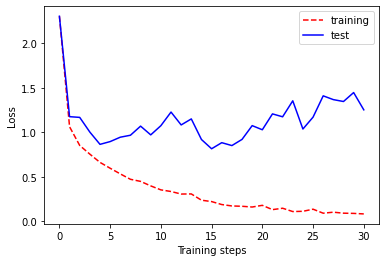

In [37]:
# Visualize accuracy and loss for training and test data. 
# One plot training and test loss.

plt.figure()
line1, = plt.plot(train_losses,'r--')
line2, = plt.plot(test_losses, 'b-')
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.legend((line1,line2),("training","test"))
plt.show()

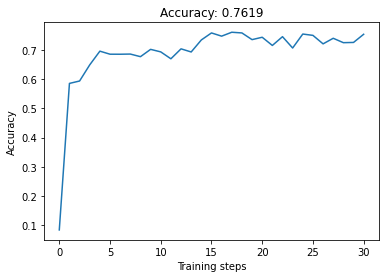

In [38]:
# One plot training and test accuracy.
plt.figure()
line1, = plt.plot(test_accuracies)
plt.xlabel("Training steps")
plt.ylabel("Accuracy" )
plt.title("Accuracy: " + str(np.round(np.max(test_accuracies),4)))
plt.show()

**3.2) ResNet**

In [48]:
#General Hyperparameters
trainforNepochs=30                                    
learning_rate=0.0001                                      
running_average_factor = 0.95                           
lossfunction= tf.keras.losses.CategoricalCrossentropy()       #we use categorical cross entropy as lossfunction
optimizer = tf.keras.optimizers.Adam(learning_rate)           #we use ADAM as optimizer

tf.keras.backend.clear_session()
model = ResNet(num_block = 3, channels_in_block = 256)  

Block 1
n_channel: 256
n_filters: 64
Block 2
n_channel: 256
n_filters: 128
Block 3
n_channel: 256
n_filters: 256


We use Regularization in our ResNet, therefore we redefine our training and test functions

In [49]:
@tf.function
def train_step(model, input, target, loss_function, optimizer, training=True):
  # loss_object and optimizer_object are instances of respective tensorflow classes
  with tf.GradientTape() as tape: #we safe the loss in the gradient tape 
    prediction = model(input, training)
    #Since we use L2 Regularization, we ensure that we take this penality score into account in our loss
    loss = loss_function(target, prediction) + tf.reduce_sum(model.losses)
    gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss 

def test(model, test_data, loss_function, training=False):
  # test over complete test data
  test_accuracy_aggregator = []
  test_loss_aggregator = []

  for (input, target) in test_data:
    prediction = model(input, training)
    #Since we use L2 Regularization, we ensure that we take this penality score into account in our loss
    sample_test_loss = loss_function(target, prediction) + tf.reduce_sum(model.losses)
    #Comparing the ratio of rightly classified images by looking at the index with max. probability 
    sample_test_accuracy = np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
    sample_test_accuracy = np.mean(sample_test_accuracy)
    test_loss_aggregator.append(sample_test_loss)
    test_accuracy_aggregator.append(np.mean(sample_test_accuracy))

  test_loss = np.mean(test_loss_aggregator)
  test_accuracy = np.mean(test_accuracy_aggregator)

  return test_loss, test_accuracy

In [50]:
# Initialize lists for later visualization.
train_losses = []
test_losses = []
test_accuracies = []

#testing once before we begin, so that be have the first datapoints
test_loss, test_accuracy = test(model, test_data, lossfunction)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

#check how model performs on train data once before we begin, so that we have a baseline
train_loss, _ = test(model, train_data, lossfunction)
train_losses.append(train_loss)

In [51]:
#After training once the model is built and we can look at its architecture and its parameters
print(model.summary())

Model: "res_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  7168      
_________________________________________________________________
residual_block (ResidualBloc multiple                  71552     
_________________________________________________________________
residual_block_1 (ResidualBl multiple                  215552    
_________________________________________________________________
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
residual_block_2 (ResidualBl multiple                  724736    
_________________________________________________________________
batch_normalization_10 (Batc multiple                  1024      
_________________________________________________________________
global_average_pooling2d (Gl multiple                  0   

This Plot was generated after 2 Epochs of training.
The test accuracy was: 0.5102507961783439 .
The highest accuracy so far was 0.5102507961783439 in epoch 2


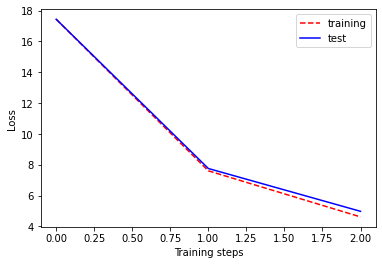

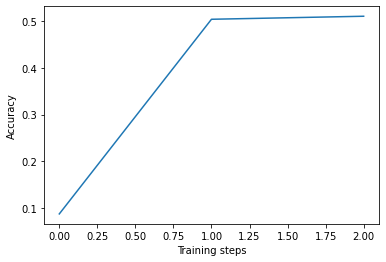

This Plot was generated after 10 Epochs of training.
The test accuracy was: 0.4443670382165605 .
The highest accuracy so far was 0.6507762738853503 in epoch 8


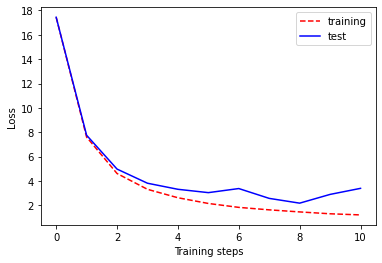

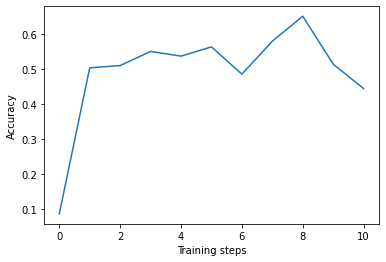

This Plot was generated after 20 Epochs of training.
The test accuracy was: 0.5433917197452229 .
The highest accuracy so far was 0.6507762738853503 in epoch 8


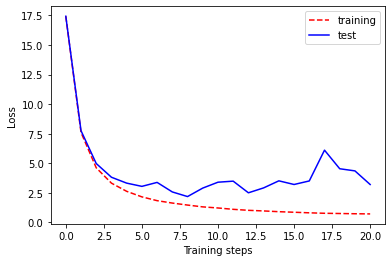

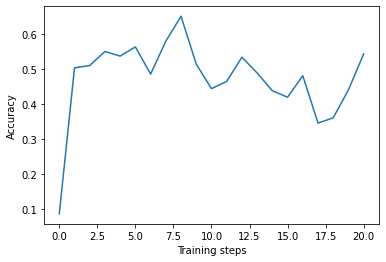

This Plot was generated after 30 Epochs of training.
The test accuracy was: 0.42018312101910826 .
The highest accuracy so far was 0.6507762738853503 in epoch 8


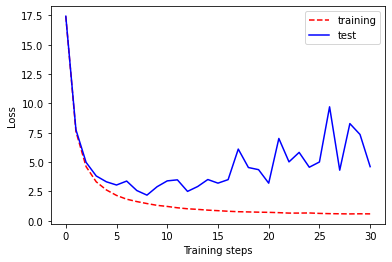

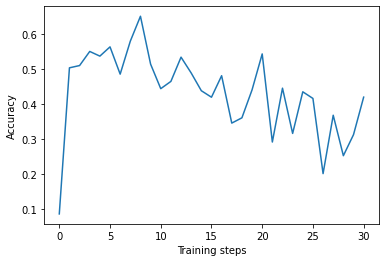

Finished after 1653.0 seconds.


In [52]:
# We train for trainforNepochs epochs.
for epoch in range(trainforNepochs):

    #!!!!!!!!!!!!just some fun runtime approximation that you can ignore :D
    if epoch == 0:              #before the first epoch we dont know how much time is going to pass.
      start = time.time()       #what we know is, when we started!
      time_remaining="Unknown"
    else:
      now = time.time()                                         
      time_per_epoch = ((now-start)/epoch)                      #average of the time per epoch
      remaining_epochs = trainforNepochs-epoch                  #numbers of remaining epochs
      time_remaining = round(time_per_epoch*remaining_epochs,0)
    print("",end="\r")
    print('Epoch:',str(epoch + 1 ),"of",str(trainforNepochs)+" Time remaining:", time_remaining, "seconds.       "+"["+"="*int((epoch/trainforNepochs)*100)+"-"*int(((trainforNepochs-epoch)/trainforNepochs)*100)+"]", end="")
    #!!!!!!!!!!!end of the runtime approximation
    


    #training (and checking in with training)
    running_average = 0
    for (input,target) in train_data:                           #Training the model as long as we have training data
        train_loss = train_step(model, input, target, lossfunction, optimizer)
        running_average = running_average_factor * running_average  + (1 - running_average_factor) * train_loss


    train_losses.append(running_average)

    #testing how good the model performed in the current step
    test_loss, test_accuracy = test(model, test_data, lossfunction)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    
    #Generating a graph after the first two epochs and after every tenth of them
    if (epoch+1)%10==0 or epoch+1==2 or epoch+1==trainforNepochs:
      print("",end="\r")
      print("This Plot was generated after", str(epoch+1), "Epochs of training.")
      print("The test accuracy was:", test_accuracies[-1],".")
      maxx,index=highest_index(test_accuracies)
      print("The highest accuracy so far was", maxx, "in epoch", index)
      viz(train_losses,test_losses,test_accuracies)

now = time.time()

print("Finished after",round(now-start,0),"seconds.")

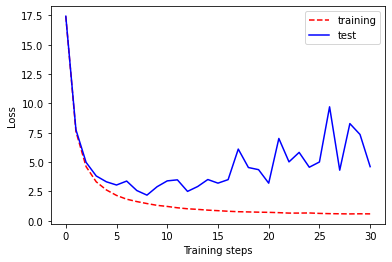

In [53]:
# Visualize accuracy and loss for training and test data. 
# One plot training and test loss.

plt.figure()
line1, = plt.plot(train_losses,'r--')
line2, = plt.plot(test_losses, 'b-')
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.legend((line1,line2),("training","test"))
plt.show()

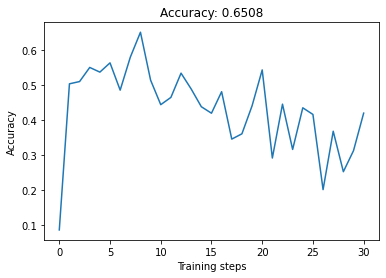

In [54]:
# One plot training and test accuracy.
plt.figure()
line1, = plt.plot(test_accuracies)
plt.xlabel("Training steps")
plt.ylabel("Accuracy" )
plt.title("Accuracy: " + str(np.round(np.max(test_accuracies),4)))
plt.show()